In [69]:
import numpy as np
from gensim.models import Word2Vec
import snap
import operator
import snap
from scipy.stats import binom
import matplotlib.pyplot as plt
import scipy
from tqdm import tqdm
from itertools import permutations

In [14]:
graph_name = "../../graphs/investors_to_companies_directed/investors_to_companies_directed_folded_reverse_order.graph"
FIn = snap.TFIn(graph_name)
G = snap.TUNGraph.Load(FIn)

In [15]:
def genErdosRenyi(N=5242, E=14484):
    """
    :param - N: number of nodes
    :param - E: number of edges

    return type: snap.PUNGraph
    return: Erdos-Renyi graph with N nodes and E edges
    """
    ############################################################################
    Graph = snap.PUNGraph.New()

    for node in range(N):
        Graph.AddNode(node)

    while Graph.GetEdges() < E:
        first = np.random.randint(0, N)
        second = np.random.randint(0, N)
        
        if first != second:
            Graph.AddEdge(first, second)

    ############################################################################
    return Graph

In [16]:
def connectRandomNodes(Graph, M=4000):
    """
    :param - Graph: snap.PUNGraph object representing an undirected graph
    :param - M: number of edges to be added

    return type: snap.PUNGraph
    return: Graph object with additional M edges added by connecting M randomly
        selected pairs of nodes not already connected.
    """
    ############################################################################
    addedEdges = 0
    N = Graph.GetNodes()

    while addedEdges < M:
        first = np.random.randint(0, N)
        second = np.random.randint(0, N)

        if not Graph.IsEdge(first, second) and first != second:
            Graph.AddEdge(first, second)
            addedEdges += 1

    ############################################################################
    return Graph

In [17]:
def connectNbrOfNbr(Graph, N=5242):
    """
    :param - Graph: snap.PUNGraph object representing a circle graph on N nodes
    :param - N: number of nodes

    return type: snap.PUNGraph
    return: Graph object with additional N edges added by connecting each node
        to the neighbors of its neighbors
    """
    ############################################################################
    for idx in range(N):
        if idx == N-2:
            Graph.AddEdge(N-2, 0)
        elif idx == N-1:
            Graph.AddEdge(N-1, 1)
        else:
            Graph.AddEdge(idx, idx + 2)
    ############################################################################
    return Graph

In [18]:
def genCircle(N=5242):
    """
    :param - N: number of nodes

    return type: snap.PUNGraph
    return: Circle graph with N nodes and N edges. Imagine the nodes form a
        circle and each node is connected to its two direct neighbors.
    """
    ############################################################################
    Graph = snap.PUNGraph.New()

    for node in range(N):
        Graph.AddNode(node)

    for idx in range(N):
        if idx == N-1:
            Graph.AddEdge(N-1, 0)
        else:
            Graph.AddEdge(idx, idx + 1)
    ############################################################################
    return Graph

In [22]:
def genSmallWorld(N=5242, E=14484):
    """
    :param - N: number of nodes
    :param - E: number of edges

    return type: snap.PUNGraph
    return: Small-World graph with N nodes and E edges
    """
    Graph = genCircle(N)
    Graph = connectNbrOfNbr(Graph, N)
    Graph = connectRandomNodes(Graph, 4000)
    return Graph

In [46]:
def gen_config_model_rewire(graph, iterations=10000):
    config_graph = graph
    clustering_coeffs = []
    ##########################################################################
    initial_num_nodes = graph.GetNodes()
    initial_num_edges = graph.GetEdges()

    num_successful_rewirings = 0

    while num_successful_rewirings < iterations:
        if num_successful_rewirings % 100 == 0:
    		clustering_coeffs.append(snap.GetClustCf(graph))

    	# Choose two nodes randomly and randomly select a neighbor for each
    	node_id_1 = graph.GetRndNId()
    	node_id_2 = graph.GetRndNId()

    	NI_1 = graph.GetNI(node_id_1)
    	NI_2 = graph.GetNI(node_id_2)

    	out_deg_1 = NI_1.GetOutDeg()
    	out_deg_2 = NI_2.GetOutDeg()

    	if out_deg_1 == 0 or out_deg_2 == 0:
    		continue

    	random_neighbor_id_1 = NI_1.GetOutNId(np.random.randint(0, out_deg_1))
    	random_neighbor_id_2 = NI_2.GetOutNId(np.random.randint(0, out_deg_2))

    	# Form e1 and e2 as described by the algorithm
    	e1 = [node_id_1, random_neighbor_id_1]
    	e2 = [node_id_2, random_neighbor_id_2]

    	# We need the edges to be distinct
    	if e1 == e2:
    		continue

    	uv = [e1[0], e1[1]] if np.random.random_sample() < 0.5 else [e1[1], e1[0]]
    	wx = [e2[0], e2[1]] if np.random.random_sample() < 0.5 else [e2[1], e2[0]]

    	if (uv[0] != wx[0]) and (uv[1] != wx[1]) and (not graph.IsEdge(uv[0], wx[0])) and (not graph.IsEdge(uv[1], wx[1])):
    		graph.DelEdge(node_id_1, random_neighbor_id_1)
    		graph.AddEdge(uv[0], wx[0])

    		graph.DelEdge(node_id_2, random_neighbor_id_2)
    		graph.AddEdge(uv[1], wx[1])

    		num_successful_rewirings += 1      

    assert(graph.GetNodes() == initial_num_nodes and graph.GetEdges() == initial_num_edges)
    ##########################################################################
    return config_graph, clustering_coeffs

In [49]:
def plot_config_clustering_coeffs(clustering_coeffs):
    '''
    Helper plotting code for question 3.1 Feel free to modify as needed.
    '''
    plt.plot(np.linspace(0,10000,len(clustering_coeffs)), clustering_coeffs)
    plt.xlabel('Iteration')
    plt.ylabel('Average Clustering Coefficient')
    plt.title('Random edge rewiring: Clustering Coefficient')
    plt.savefig('q3_1.png', format='png')
    plt.show()

In [51]:
def load_3_subgraphs():
    '''
    Loads a list of all 13 directed 3-subgraphs.
    The list is in the same order as the figure in the HW pdf, but it is
    zero-indexed
    '''
    return [snap.LoadEdgeList(snap.PNGraph, "./subgraphs/{}.txt".format(i), 0, 1) for i in range(13)]

In [67]:
def match(G1, G2):
    '''
    This function compares two graphs of size 3 (number of nodes)
    and checks if they are isomorphic.
    It returns a boolean indicating whether or not they are isomorphic
    You should not need to modify it, but it is also not very elegant...
    '''
    if G1.GetEdges() > G2.GetEdges():
        G = G1
        H = G2
    else:
        G = G2
        H = G1
    # Only checks 6 permutations, since k = 3
    for p in permutations(range(3)):
        edge = G.BegEI()
        matches = True
        while edge < G.EndEI():
            if not H.IsEdge(p[edge.GetSrcNId()], p[edge.GetDstNId()]):
                matches = False
                break
            edge.Next()
        if matches:
            break
    return matches

In [65]:
def count_iso(G, sg, verbose=False):
    '''
    Given a set of 3 node indices in sg, obtains the subgraph from the
    original graph and renumbers the nodes from 0 to 2.
    It then matches this graph with one of the 13 graphs in
    directed_3.
    When it finds a match, it increments the motif_counts by 1 in the relevant
    index

    IMPORTANT: counts are stored in global motif_counts variable.
    It is reset at the beginning of the enumerate_subgraph method.
    '''
    if verbose:
       print(sg)
    nodes = snap.TIntV()
    for NId in sg:
        nodes.Add(NId)
    # This call requires latest version of snap (4.1.0)
    SG = snap.GetSubGraphRenumber(G, nodes)
    for i in range(len(directed_3)):
        if match(directed_3[i], SG):
            motif_counts[i] += 1

In [61]:
def enumerate_subgraph(G, k=3, verbose=False):
    '''
    This is the main function of the ESU algorithm.
    Here, you should iterate over all nodes in the graph,
    find their neighbors with ID greater than the current node
    and issue the recursive call to extend_subgraph in each iteration

    A good idea would be to print a progress report on the cycle over nodes,
    So you get an idea of how long the algorithm needs to run
    '''
    global motif_counts
    motif_counts = [0]*len(directed_3) # Reset the motif counts (Do not remove)
    ##########################################################################
    counter = 0
    totalNodes = G.GetNodes()

    for NI in G.Nodes():
    	counter += 1
    	print "On node " + str(counter) + " of " + str(totalNodes)

    	curr_id = NI.GetId()
    	curr_deg = NI.GetDeg()
    	sg = set([curr_id])

    	v_ext = set()
    	for neighbor_idx in range(curr_deg):
    		neighbor_id = NI.GetNbrNId(neighbor_idx)
    		if neighbor_id > curr_id:
    			v_ext.add(neighbor_id)

    	extend_subgraph(G, 3, sg, v_ext, curr_id, verbose)
    ##########################################################################

In [62]:
def extend_subgraph(G, k, sg, v_ext, node_id, verbose=False):
    '''
    This is the recursive function in the ESU algorithm
    The base case is already implemented and calls count_iso. You should not
    need to modify this.

    Implement the recursive case.
    '''
    # Base case (you should not need to modify this):
    if len(sg) is k:
        count_iso(G, sg, verbose)
        return
    # Recursive step:
    #########################################################################
    v_ext_original = v_ext.copy()
    while len(v_ext) > 0:
		# Pick a random node to remove from v_ext
		# Add it to a copy of sg and recurse on the new sg.
		# Use copy to reflect the cases where we do and do
		# not choose to extend through this node.
		sg_copy = sg.copy()
		extension_node_id = v_ext.pop()
		sg_copy.add(extension_node_id)


		# Make a copy of v_ext to be passed to the next recursive call
		v_ext_copy = v_ext.copy()

		# Loop over all of the neighbors of the randomly chosen node
		extension_NI = G.GetNI(extension_node_id)
		extension_deg = extension_NI.GetDeg()
		for neighbor_idx in range(extension_deg):
			neighbor_id = extension_NI.GetNbrNId(neighbor_idx)    	
			
			# Before adding a node to v_ext_new, we require the following:
			# (1) Must have an ID greater than the original node ID
			# (2) Can't be in the original version of v_ext
			# (3) Can't already be in new_sg
			if (neighbor_id > node_id) and (neighbor_id not in v_ext_original) and (neighbor_id not in sg_copy):
				v_ext_copy.add(neighbor_id)

		extend_subgraph(G, 3, sg_copy, v_ext_copy, node_id, verbose)

In [63]:
def compute_Z_Scores():

	real_graph_counts = np.load(fname)
	config_motif_counts = np.load(config_fname)

	config_mean = np.mean(config_motif_counts, axis=0)
	config_std_dev = np.std(config_motif_counts, axis=0)

	Z_Scores = (real_graph_counts - config_mean) / config_std_dev
	motif_indices = np.arange(1, 14)

	plt.plot(motif_indices, Z_Scores)
	if power_grid:
		plt.title("Z Score vs. Motif Index for Power Grid Graph")
	else:
		plt.title("Z Score vs. Motif Index for Email Graph")
	plt.xlabel("Motif index")
	plt.ylabel("Z Score")
	plt.show()

In [59]:
# Get our null models for comparison
G_Erdos_Renyi = genErdosRenyi(G.GetNodes(), G.GetEdges())
G_Small_World = genSmallWorld(G.GetNodes(), G.GetEdges())
G_Config, clustering_coeffs = gen_config_model_rewire(G, 10000)

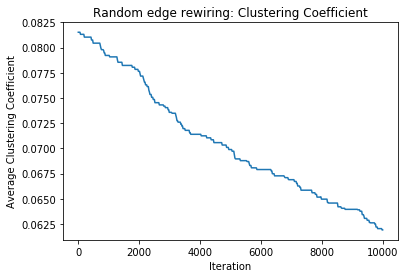

In [60]:
# Sanity check on the config model we just generated
plot_config_clustering_coeffs(clustering_coeffs)

In [70]:
# Compute motif counts in the folded graph
# ISSUE: HW question was for directed graphs
# But the folded graph is undirected
directed_3 = load_3_subgraphs()
motif_counts = [0]*len(directed_3)
enumerate_subgraph(G, 3, False)
print motif_counts
np.save("FoldedGraphMotifCounts", np.array(motif_counts))

On node 1 of 11572
On node 2 of 11572
On node 3 of 11572
On node 4 of 11572
On node 5 of 11572
On node 6 of 11572
On node 7 of 11572
On node 8 of 11572
On node 9 of 11572
On node 10 of 11572
On node 11 of 11572


KeyboardInterrupt: 